# Flax-pilot Trainer with pre-trained models


**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu
!pip install -q flax-pilot

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.17.0 which is incompatible.


In [2]:
import jax
import optax
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr

In [3]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.20')

**Refer to the `mnist-class` and `mnist-vae` for single optimizing without frozen pre-trained and refer to `mnist-vae-gan-cfg` for multi-optimization without pre-trained and use this notebook for single & multi optimization with frozen pre-trained layers.**

## Single-optimization with Frozen pre-trained

### First let's create a pre-trained classifier model on MNIST dataset and later we can use the trained backbone of that model for finetuning.

**BackBone for pre-training**<br>
Once trained, we can use the trained backbone weights for other finetuning tasks

In [4]:
class BackBone(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x

**Feed forward layer**<br>
A feed forward classifier

In [5]:
class FeedForward(nn.Module):
    num_classes: int

    @nn.compact
    def __call__(self, x, deterministic):
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(features=256)(x)
        x = nn.Dropout(rate=0.3, deterministic=deterministic)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)
        return x

**Encapsulate both the backbone and classifier**

In [6]:
class Classifier(nn.Module):

    def setup(self, ):
        self.base = BackBone()
        self.ff = FeedForward(10)

    @nn.compact
    def __call__(self, x, deterministic):
        return self.ff(self.base(x, deterministic), deterministic)

**Load the data**

In [7]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x78dabb9bda50>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x78dabb9bedd0>))

**Loss metric function**

In [8]:
def loss_fn(params, apply, sample, deterministic, global_key, step):
    x, y = sample
    yp = apply(params, x, deterministic=deterministic, rngs={'dropout': global_key})
    loss = optax.softmax_cross_entropy(yp, y).mean()
    yp = nn.softmax(yp, axis=-1)
    loss_metric_values_dict = {
        'lt': {'loss': loss},
        'mt': {'f1': (y, yp), 'acc': (y, yp), 'pre': (y, yp), 'rec': (y, yp)}
    }
    return loss, loss_metric_values_dict

**Loss metric dict**

In [9]:
from fpilot import BasicTrackers as tr

trackers = {
        'lt': {'loss': tr.Mean()},
        'mt':{'f1': tr.F1Score(num_classes=10, threshold=0.7, average='macro'), 'acc': tr.Accuracy(),
              'pre': tr.Precision(num_classes=10, threshold=0.7, average='micro'),
              'rec': tr.Recall(num_classes=10, threshold=0.7, average='macro')
             }
}

In [10]:
from fpilot import Trainer
pre_trainer = Trainer(Classifier(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn, trackers, True)

**Train**

In [11]:
pre_trainer.train(10, train_ds, val_ds, 60000//256, 10000//256, "/kaggle/working/pre-trained-models/mnist", 3)

Epoch 1: 100%|██████████| 234/234 [00:04<00:00, 52.60it/s] 


Train:  loss: 0.29120773, acc: 0.91644967, f1: 0.89369833, pre: 0.97373044, rec: 0.8272231, time: 4.451971769332886
Val:  loss: 0.072393745, acc: 0.9772636, f1: 0.9729225, pre: 0.9883283, rec: 0.9581539, time: 1.2240126132965088
State saved..


Epoch 2: 100%|██████████| 234/234 [00:00<00:00, 350.20it/s]


Train:  loss: 0.08135511, acc: 0.9753773, f1: 0.9710701, pre: 0.9889285, rec: 0.9540275, time: 0.6703784465789795
Val:  loss: 0.04672874, acc: 0.9846755, f1: 0.9826116, pre: 0.99365276, rec: 0.97183686, time: 0.07473587989807129
State saved..


Epoch 3: 100%|██████████| 234/234 [00:00<00:00, 365.15it/s]


Train:  loss: 0.054681376, acc: 0.98302287, f1: 0.98031026, pre: 0.99205387, rec: 0.9689118, time: 0.6440291404724121
Val:  loss: 0.03602815, acc: 0.9879808, f1: 0.98626035, pre: 0.99379927, rec: 0.9789756, time: 0.07312130928039551
State saved..


Epoch 4: 100%|██████████| 234/234 [00:00<00:00, 393.28it/s]


Train:  loss: 0.042720567, acc: 0.9865953, f1: 0.984508, pre: 0.99339056, rec: 0.97585326, time: 0.5981252193450928
Val:  loss: 0.035847303, acc: 0.9881811, f1: 0.98626417, pre: 0.99410117, rec: 0.97867346, time: 0.07523131370544434
State saved..


Epoch 5: 100%|██████████| 234/234 [00:00<00:00, 393.00it/s]


Train:  loss: 0.036711365, acc: 0.9887153, f1: 0.9869601, pre: 0.99450976, rec: 0.97956353, time: 0.5981614589691162
Val:  loss: 0.028878856, acc: 0.98978364, f1: 0.98836756, pre: 0.99482584, rec: 0.98210204, time: 0.08045172691345215
State saved..


Epoch 6: 100%|██████████| 234/234 [00:00<00:00, 352.11it/s]


Train:  loss: 0.029277157, acc: 0.99111915, f1: 0.98974913, pre: 0.9956428, rec: 0.9839627, time: 0.6676046848297119
Val:  loss: 0.026602522, acc: 0.99058497, f1: 0.9894077, pre: 0.99503744, rec: 0.9839293, time: 0.07609295845031738
State saved..


Epoch 7: 100%|██████████| 234/234 [00:00<00:00, 392.95it/s]


Train:  loss: 0.025193073, acc: 0.9917368, f1: 0.9906606, pre: 0.9959012, rec: 0.9854993, time: 0.5982780456542969
Val:  loss: 0.025351275, acc: 0.9903846, f1: 0.989988, pre: 0.9950435, rec: 0.9851004, time: 0.07165765762329102
State saved..


Epoch 8: 100%|██████████| 234/234 [00:00<00:00, 392.03it/s]


Train:  loss: 0.022075249, acc: 0.9925214, f1: 0.9918545, pre: 0.99652886, rec: 0.9872241, time: 0.5994508266448975
Val:  loss: 0.0247347, acc: 0.99078524, f1: 0.9905883, pre: 0.9950496, rec: 0.9862034, time: 0.07240843772888184
State saved..


Epoch 9: 100%|██████████| 234/234 [00:00<00:00, 392.09it/s]


Train:  loss: 0.020149479, acc: 0.99342287, f1: 0.9925319, pre: 0.9966005, rec: 0.98851216, time: 0.5998315811157227
Val:  loss: 0.025220279, acc: 0.99108577, f1: 0.99076444, pre: 0.995051, rec: 0.986625, time: 0.07575631141662598
State saved..


Epoch 10: 100%|██████████| 234/234 [00:00<00:00, 391.91it/s]


Train:  loss: 0.017780796, acc: 0.9943911, f1: 0.9935257, pre: 0.9973591, rec: 0.9897224, time: 0.5997200012207031
Val:  loss: 0.02738159, acc: 0.99038464, f1: 0.98961973, pre: 0.9938398, rec: 0.9855599, time: 0.07591485977172852
State saved..


In [12]:
pre_trainer.evaluate(val_ds, 10000//256)

Val:  loss: 0.027320342, acc: 0.99038464, f1: 0.9896598, pre: 0.9938396, rec: 0.9856224, time: 0.07231640815734863


**Save the checkpoint**

In [13]:
# args: location to save checkpoint
pre_trainer.save_state('/kaggle/working/pre-trained-models/manual_mnist_save2')

State saved..


**Check results**

In [14]:
sample = next(val_ds)
x, y = sample[0][:, :8], sample[1][:, :8]

rngs = {} # no rng needed bcz prediction doesnt require dropout
tensor_inputs = {'x': x}

yp = pre_trainer(rngs, tensor_inputs, deterministic=True)
yp = nn.softmax(yp, axis=-1).argmax(axis=-1)

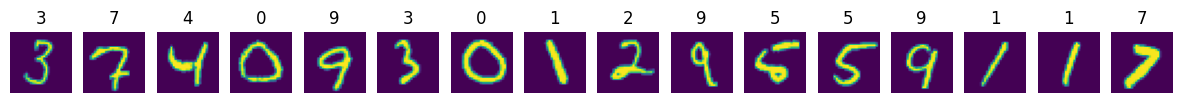

In [15]:
import matplotlib.pyplot as plt

yp = yp.reshape(16, -1)
x = x.reshape(16, 28, 28, 1)

plot_images = iter(x)
labels = iter(yp)
fig, ax = plt.subplots(1, 16, figsize=(15, 15))

for i in range(16):
        ax[i].imshow(next(plot_images))
        ax[i].set_title(str(next(labels)[0]))
        ax[i].axis('off')

### Fine-tuning

**Lets use the backbone params for other tasks. In this example lets use the trained backbone for Encoder part of VAE**


**Extract the params of backbone**

In [16]:
temp_ckpt = orbax.checkpoint.PyTreeCheckpointer()
classifier_state = temp_ckpt.restore("/kaggle/working/pre-trained-models/manual_mnist_save2/2340/default")
base_params = classifier_state['params']['params']['base']

/opt/conda/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1407: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


**VAE Model**

**Lets use the backbone in the encoder.**

In [17]:
class Encoder(nn.Module):
    base: nn.Module = BackBone()

    def setup(self,):
        self.ff = nn.Sequential([
            nn.Dense(16),
            nn.relu,
            nn.Dense(4)
        ])


    def __call__(self, x, deterministic):
        x = self.base(x, deterministic)
        x = x.reshape(x.shape[0], -1)
        x = self.ff(x)
        mean, logvar = jnp.split(x, 2, -1)
        return mean, logvar


class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z):
        y = nn.relu(nn.Dense(49*64)(z))
        y = y.reshape(y.shape[0], 7, 7, 64)
        y = nn.relu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.relu(nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y


class VAE(nn.Module):
    encoder: nn.Module = Encoder()
    decoder: nn.Module = Decoder()

    # Must have 'deterministic param'.
    @nn.compact
    def __call__(self, x, deterministic):
        mean, logvar = self.encode(x, deterministic)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z)
        return (mean, logvar), y

    def encode(self, x, deterministic):
        return self.encoder(x, deterministic)

    def decode(self, x):
        return self.decoder(x)

    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e

**Loss function for VAE**

In [18]:
def loss_fn(params, apply, sample, deterministic, global_key, step):
    x, _ = sample
    (mean, logvar), y = apply(params, x, deterministic=deterministic, rngs={'normal': global_key})

    recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log(1-y+0.00001)).sum(axis=(1, 2)).mean()
    kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
    loss = recons_loss + kl_loss
    loss_metric_values_dict = {
        'lt': {'kl_loss': kl_loss.mean(), 'recons_loss': recons_loss.mean()},
        'mt': dict()
        }
    return loss, loss_metric_values_dict

**Trackers for VAE**

In [19]:
from fpilot import BasicTrackers as tr

trackers = {
        'lt': {'kl_loss': tr.Mean(), 'recons_loss': tr.Mean()},
        'mt':{}
}

**Create optimizer mask**


 - True: Apply Gradients
 - False: Dont Apply Gradients

 #### Note  
 When setting masks for layers or models, if a mask is specified for a particular child node, it is mandatory to also set masks for all its sibling nodes. For example, if you set a mask for `base`, you must also set a mask for `ff`.By explicitly setting the mask for each relevant part of the model, you ensure that gradient updates are applied correctly as per your specified structure. So, whenever you set a mask for one part of a node, you also set masks for all its sibling parts, maintaining completeness and clarity in the configuration. <br><br>
When dealing with pre-trained layers, it is important to separate the pre-trained and trainable layers into different modules. Then, encapsulate both modules within a parent model. For example, if a module has 5 layers and 1 frozen layer, you would need to set a mask for all 6 siblings. However, if you separate the trainable and non-trainable layers into submodules and encapsulate them, you only need to set masks for these two submodules, simplifying the configuration.

In [20]:
mask = {
    'params': # first key `params` is default for any mask.
        {
            'encoder': {
                'base': False,
                'ff': True
            },
            'decoder': True
        }
}

**Initiate trainer**

In [21]:
vae_trainer = Trainer(VAE(),
                      {'x': (1, 28, 28, 1)},
                       optax.adam(0.0001),
                       loss_fn,
                       trackers,
                       mask)

**Set the params of Backbone to its pre-trained weights**<br>
Check the docstring of the function for explaination

In [22]:
replacement_path = [
    ['params', 'encoder', 'base']
]
replacement_params = [
    base_params
]
vae_trainer.transfer_params(replacement_path, replacement_params)

**Lets check if the weights are transferred**

In [23]:
pre_base_params = pre_trainer.state.params['params']['base']
vae_base_params = vae_trainer.state.params['params']['encoder']['base']
results = jax.tree_util.tree_map(lambda x, y: jnp.array_equal(x, y), pre_base_params, vae_base_params)
results

{'Conv_0': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)},
 'Conv_1': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)}}

**Train the VAE**

In [27]:
vae_trainer.train(30, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/pilot-examples/vae_v2', 3)

Epoch 1: 100%|██████████| 234/234 [00:01<00:00, 178.77it/s]


Train:  kl_loss: 6.0572205, recons_loss: 154.3046, time: 1.3116180896759033
Val:  kl_loss: 6.067195, recons_loss: 154.41257, time: 0.07467508316040039
State saved..


Epoch 2: 100%|██████████| 234/234 [00:01<00:00, 178.55it/s]


Train:  kl_loss: 6.0732603, recons_loss: 153.98302, time: 1.313171148300171
Val:  kl_loss: 6.0647507, recons_loss: 154.00601, time: 0.07297611236572266
State saved..


Epoch 3: 100%|██████████| 234/234 [00:01<00:00, 177.95it/s]


Train:  kl_loss: 6.085103, recons_loss: 153.64912, time: 1.317866563796997
Val:  kl_loss: 6.0893984, recons_loss: 153.67029, time: 0.07655596733093262
State saved..


Epoch 4: 100%|██████████| 234/234 [00:01<00:00, 176.97it/s]


Train:  kl_loss: 6.095251, recons_loss: 153.36676, time: 1.3249294757843018
Val:  kl_loss: 6.0947285, recons_loss: 153.49261, time: 0.07847929000854492
State saved..


Epoch 5: 100%|██████████| 234/234 [00:01<00:00, 176.86it/s]


Train:  kl_loss: 6.1217556, recons_loss: 153.09798, time: 1.3256165981292725
Val:  kl_loss: 6.1364784, recons_loss: 152.97827, time: 0.0737309455871582
State saved..


Epoch 6: 100%|██████████| 234/234 [00:01<00:00, 176.90it/s]


Train:  kl_loss: 6.134402, recons_loss: 152.81331, time: 1.3254032135009766
Val:  kl_loss: 6.1457014, recons_loss: 152.8757, time: 0.07796311378479004
State saved..


Epoch 7: 100%|██████████| 234/234 [00:01<00:00, 176.12it/s]


Train:  kl_loss: 6.137866, recons_loss: 152.5907, time: 1.3314714431762695
Val:  kl_loss: 6.1558094, recons_loss: 152.55286, time: 0.07776045799255371
State saved..


Epoch 8: 100%|██████████| 234/234 [00:01<00:00, 175.44it/s]


Train:  kl_loss: 6.163252, recons_loss: 152.3428, time: 1.33652663230896
Val:  kl_loss: 6.1790957, recons_loss: 152.45541, time: 0.09596800804138184
State saved..


Epoch 9: 100%|██████████| 234/234 [00:01<00:00, 175.37it/s]


Train:  kl_loss: 6.1708875, recons_loss: 152.09933, time: 1.3369879722595215
Val:  kl_loss: 6.1954036, recons_loss: 152.19164, time: 0.07642555236816406
State saved..


Epoch 10: 100%|██████████| 234/234 [00:01<00:00, 175.03it/s]


Train:  kl_loss: 6.193387, recons_loss: 151.8735, time: 1.3394842147827148
Val:  kl_loss: 6.1983767, recons_loss: 151.96056, time: 0.0786738395690918
State saved..


Epoch 11: 100%|██████████| 234/234 [00:01<00:00, 175.44it/s]


Train:  kl_loss: 6.1875763, recons_loss: 151.70499, time: 1.3364129066467285
Val:  kl_loss: 6.202341, recons_loss: 151.80237, time: 0.07552242279052734
State saved..


Epoch 12: 100%|██████████| 234/234 [00:01<00:00, 174.57it/s]


Train:  kl_loss: 6.197593, recons_loss: 151.49765, time: 1.3436014652252197
Val:  kl_loss: 6.202749, recons_loss: 151.75351, time: 0.07460379600524902
State saved..


Epoch 13: 100%|██████████| 234/234 [00:01<00:00, 174.19it/s]


Train:  kl_loss: 6.207861, recons_loss: 151.29594, time: 1.345942735671997
Val:  kl_loss: 6.216131, recons_loss: 151.61313, time: 0.07671165466308594
State saved..


Epoch 14: 100%|██████████| 234/234 [00:01<00:00, 173.77it/s]


Train:  kl_loss: 6.218933, recons_loss: 151.07495, time: 1.3491621017456055
Val:  kl_loss: 6.2290587, recons_loss: 151.49655, time: 0.07873296737670898
State saved..


Epoch 15: 100%|██████████| 234/234 [00:01<00:00, 173.70it/s]


Train:  kl_loss: 6.2186384, recons_loss: 150.9386, time: 1.3496990203857422
Val:  kl_loss: 6.2252502, recons_loss: 151.24107, time: 0.07394623756408691
State saved..


Epoch 16: 100%|██████████| 234/234 [00:01<00:00, 173.66it/s]


Train:  kl_loss: 6.239707, recons_loss: 150.74075, time: 1.3502120971679688
Val:  kl_loss: 6.2506905, recons_loss: 151.26828, time: 0.07355356216430664
State saved..


Epoch 17: 100%|██████████| 234/234 [00:01<00:00, 172.79it/s]


Train:  kl_loss: 6.2476063, recons_loss: 150.57701, time: 1.3568475246429443
Val:  kl_loss: 6.262986, recons_loss: 150.95177, time: 0.08199787139892578
State saved..


Epoch 18: 100%|██████████| 234/234 [00:01<00:00, 173.15it/s]


Train:  kl_loss: 6.254812, recons_loss: 150.43936, time: 1.3545069694519043
Val:  kl_loss: 6.2506094, recons_loss: 150.75854, time: 0.07988667488098145
State saved..


Epoch 19: 100%|██████████| 234/234 [00:01<00:00, 173.02it/s]


Train:  kl_loss: 6.265784, recons_loss: 150.31473, time: 1.3551726341247559
Val:  kl_loss: 6.2659407, recons_loss: 150.68695, time: 0.07749247550964355
State saved..


Epoch 20: 100%|██████████| 234/234 [00:01<00:00, 172.97it/s]


Train:  kl_loss: 6.271859, recons_loss: 150.12639, time: 1.3554871082305908
Val:  kl_loss: 6.274391, recons_loss: 150.66121, time: 0.07676959037780762
State saved..


Epoch 21: 100%|██████████| 234/234 [00:01<00:00, 173.66it/s]


Train:  kl_loss: 6.2782993, recons_loss: 150.02917, time: 1.3502767086029053
Val:  kl_loss: 6.2937894, recons_loss: 150.3378, time: 0.07541751861572266
State saved..


Epoch 22: 100%|██████████| 234/234 [00:01<00:00, 174.03it/s]


Train:  kl_loss: 6.292261, recons_loss: 149.85193, time: 1.347486972808838
Val:  kl_loss: 6.301069, recons_loss: 150.32663, time: 0.07662844657897949
State saved..


Epoch 23: 100%|██████████| 234/234 [00:01<00:00, 174.66it/s]


Train:  kl_loss: 6.301219, recons_loss: 149.75696, time: 1.3425333499908447
Val:  kl_loss: 6.280628, recons_loss: 150.45679, time: 0.07785487174987793
State saved..


Epoch 24: 100%|██████████| 234/234 [00:01<00:00, 174.90it/s]


Train:  kl_loss: 6.294018, recons_loss: 149.60342, time: 1.3408057689666748
Val:  kl_loss: 6.2846503, recons_loss: 150.12674, time: 0.08222723007202148
State saved..


Epoch 25: 100%|██████████| 234/234 [00:01<00:00, 174.90it/s]


Train:  kl_loss: 6.310232, recons_loss: 149.46628, time: 1.341048240661621
Val:  kl_loss: 6.302571, recons_loss: 150.02066, time: 0.07863450050354004
State saved..


Epoch 26: 100%|██████████| 234/234 [00:01<00:00, 175.61it/s]


Train:  kl_loss: 6.3203135, recons_loss: 149.33426, time: 1.3350305557250977
Val:  kl_loss: 6.3214154, recons_loss: 150.06537, time: 0.07977533340454102
State saved..


Epoch 27: 100%|██████████| 234/234 [00:01<00:00, 175.23it/s]


Train:  kl_loss: 6.324352, recons_loss: 149.24138, time: 1.3379955291748047
Val:  kl_loss: 6.3254523, recons_loss: 149.84354, time: 0.0771484375
State saved..


Epoch 28: 100%|██████████| 234/234 [00:01<00:00, 175.30it/s]


Train:  kl_loss: 6.332753, recons_loss: 149.15948, time: 1.3377537727355957
Val:  kl_loss: 6.3279147, recons_loss: 149.87798, time: 0.08007431030273438
State saved..


Epoch 29: 100%|██████████| 234/234 [00:01<00:00, 176.26it/s]


Train:  kl_loss: 6.3391094, recons_loss: 149.00275, time: 1.3303799629211426
Val:  kl_loss: 6.3339157, recons_loss: 149.4696, time: 0.07527709007263184
State saved..


Epoch 30: 100%|██████████| 234/234 [00:01<00:00, 176.34it/s]


Train:  kl_loss: 6.3468866, recons_loss: 148.8766, time: 1.3298702239990234
Val:  kl_loss: 6.355978, recons_loss: 149.37793, time: 0.07248497009277344
State saved..


**Lets check if weights have changed**

In [30]:
pre_base_params = pre_trainer.state.params['params']['base']
vae_base_params = vae_trainer.state.params['params']['encoder']['base']
results = jax.tree_util.tree_map(lambda x, y: jnp.array_equal(x, y), pre_base_params, vae_base_params)
results

{'Conv_0': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)},
 'Conv_1': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)}}

The above output shows that the weights of the backbone haven't changed during VAE training ensuring frozen weights

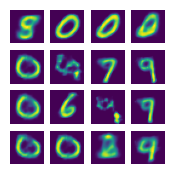

In [45]:
rand = jr.normal(jr.PRNGKey(10), (2, 8, 2))

rngs = {'normal': jax.random.PRNGKey(17)}
tensor_inputs = {'x': rand}

output = vae_trainer(rngs, tensor_inputs, method='decode')

plot_images = iter(output.reshape(16, 28, 28, 1))
fig, ax = plt.subplots(4, 4, figsize=(2, 2))

for x in range(4):
    for y in range(4):
        ax[x, y].imshow(next(plot_images))
        ax[x, y].axis('off')

Further training will lead to better results.

### Multi-optimization using pre-trained models.

**Accessible [here](https://github.com/NITHISHM2410/flax-pilot/blob/main/examples/vae-gan-cfg-using-pretrained.ipynb)**